In [25]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets

import utils.metrics
import utils.model

import models.mnist

In [18]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [19]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.ToTensor()])

data_train = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=True, transform=transforms)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

In [20]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [24]:
model = models.mnist.LeNet5_dropout(p_dropout=0).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = utils.model.train_model(
    model, 20, optimizer, criterion, data_loaders, device)

LeNet5_dropout(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): Dropout2d(p=0, inplace=False)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): Dropout2d(p=0, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)
Epoch 1/20
----------


train Loss: 0.58 Acc: 0.79 Avg. conf: 0.73 Avg. max. prob: 0.77: 100%|██████████| 1875/1875 [00:10<00:00, 180.10it/s]
val Loss: 0.47 Acc: 0.83 Avg. conf: 0.80 Avg. max. prob: 0.84: 100%|██████████| 313/313 [00:01<00:00, 242.42it/s]

Epoch 2/20
----------



train Loss: 0.40 Acc: 0.85 Avg. conf: 0.82 Avg. max. prob: 0.85: 100%|██████████| 1875/1875 [00:10<00:00, 177.52it/s]
val Loss: 0.42 Acc: 0.85 Avg. conf: 0.83 Avg. max. prob: 0.86: 100%|██████████| 313/313 [00:01<00:00, 243.80it/s]

Epoch 3/20
----------



train Loss: 0.35 Acc: 0.87 Avg. conf: 0.84 Avg. max. prob: 0.87: 100%|██████████| 1875/1875 [00:10<00:00, 180.28it/s]
val Loss: 0.37 Acc: 0.86 Avg. conf: 0.85 Avg. max. prob: 0.87: 100%|██████████| 313/313 [00:01<00:00, 241.92it/s]

Epoch 4/20
----------



train Loss: 0.32 Acc: 0.88 Avg. conf: 0.86 Avg. max. prob: 0.88: 100%|██████████| 1875/1875 [00:10<00:00, 176.20it/s]
val Loss: 0.34 Acc: 0.88 Avg. conf: 0.86 Avg. max. prob: 0.88: 100%|██████████| 313/313 [00:01<00:00, 239.53it/s]

Epoch 5/20
----------



train Loss: 0.30 Acc: 0.89 Avg. conf: 0.87 Avg. max. prob: 0.89: 100%|██████████| 1875/1875 [00:10<00:00, 179.39it/s]
val Loss: 0.35 Acc: 0.87 Avg. conf: 0.86 Avg. max. prob: 0.88: 100%|██████████| 313/313 [00:01<00:00, 249.55it/s]

Epoch 6/20
----------



train Loss: 0.28 Acc: 0.89 Avg. conf: 0.87 Avg. max. prob: 0.89:  20%|██        | 376/1875 [00:02<00:08, 185.52it/s]


KeyboardInterrupt: 

In [33]:
utils.mc_dropout.set_dropout_p(model, model, .15)
progress = utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, use_mc_dropout=True)

Avg. acc.: 87.68: 100%|██████████| 313/313 [00:05<00:00, 55.79it/s]


Accuracy: 87.68%, NLL: 0.331754


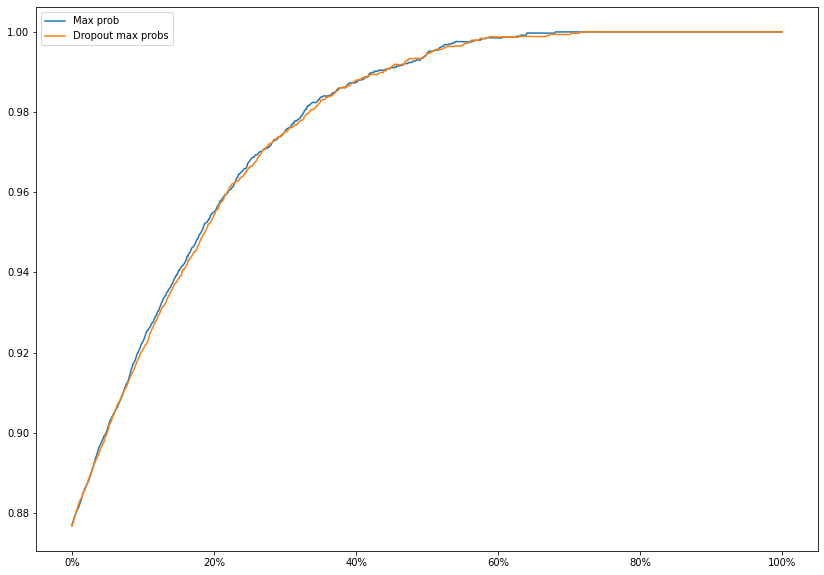

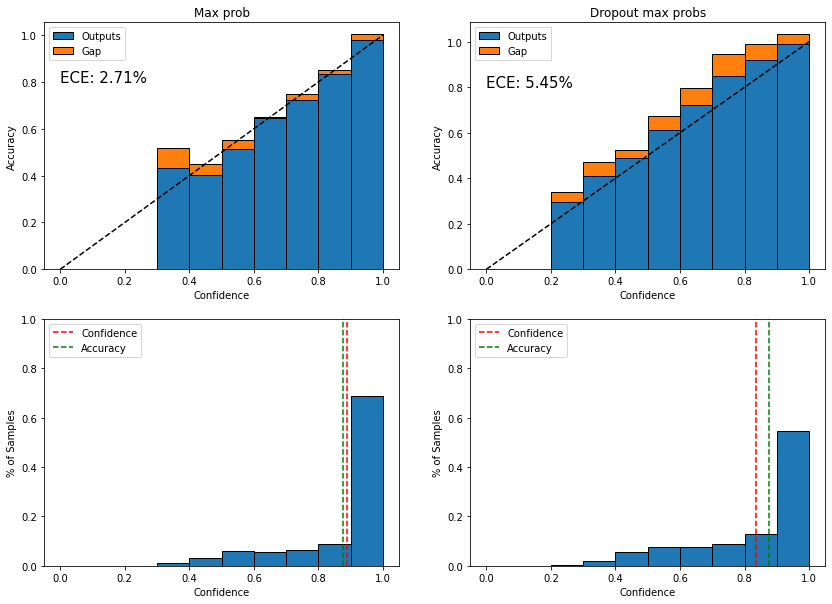

In [51]:
nll = criterion(torch.tensor(progress.logits), torch.tensor(
    progress.labels, dtype=torch.long)).item()
print(
    f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
    f"NLL: {nll:4f}"
)

# mc_logits = progress.dropout_logits.mean(axis=0)
dropout_max_probs = progress.dropout_outputs.max(axis=-1)

utils.visualisations.samples_removed_vs_acc([
    ("Max prob", np.argsort(progress.max_probs)),
    ("Dropout max probs", np.argsort(dropout_max_probs))],
    progress.labels,
    progress.predictions,
    progress.dropout_predictions)


counts = utils.visualisations.calibration_graph([
    ("Max prob", progress.max_probs, np.argsort(progress.max_probs)),
    ("Dropout max probs", dropout_max_probs, np.argsort(dropout_max_probs))],
    progress.labels,
    progress.predictions,
    progress.dropout_predictions)